In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
column_name = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]

In [3]:
data = pd.read_csv("auto-mpg.data", names = column_name, na_values = "?", comment ="\t", sep = " ", skipinitialspace = True)

In [4]:
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [5]:
data = data.rename(columns = {"MPG":"target"})

In [6]:
print("Data shape: ", data.shape)

Data shape:  (398, 8)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [8]:
describe = data.describe()

In [9]:
print(data.isna().sum())

target          0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [10]:
data["Horsepower"] = data["Horsepower"].fillna(data["Horsepower"].mean())

In [11]:
print(data.isna().sum())

target          0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


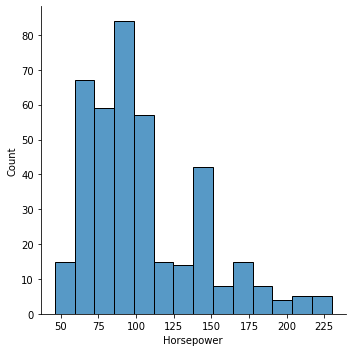

In [12]:
sns.displot(data.Horsepower)

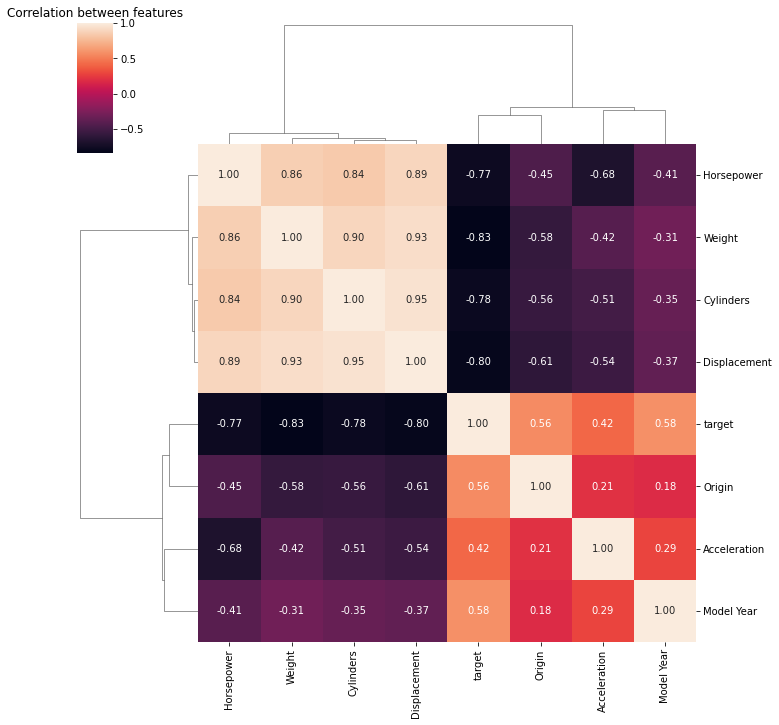

In [13]:
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot  = True, fmt = ".2f")
plt.title("Correlation between features")
plt.show()

## Multicollinearity (Eşdüzlemlilik)

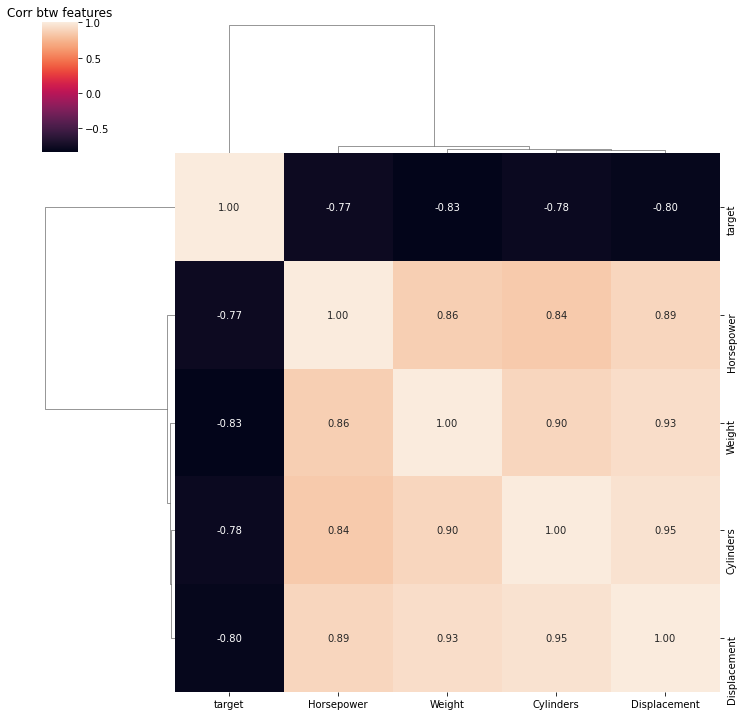

In [14]:
threshold = 0.75
filtre = np.abs(corr_matrix["target"])>threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Corr btw features")
plt.show()

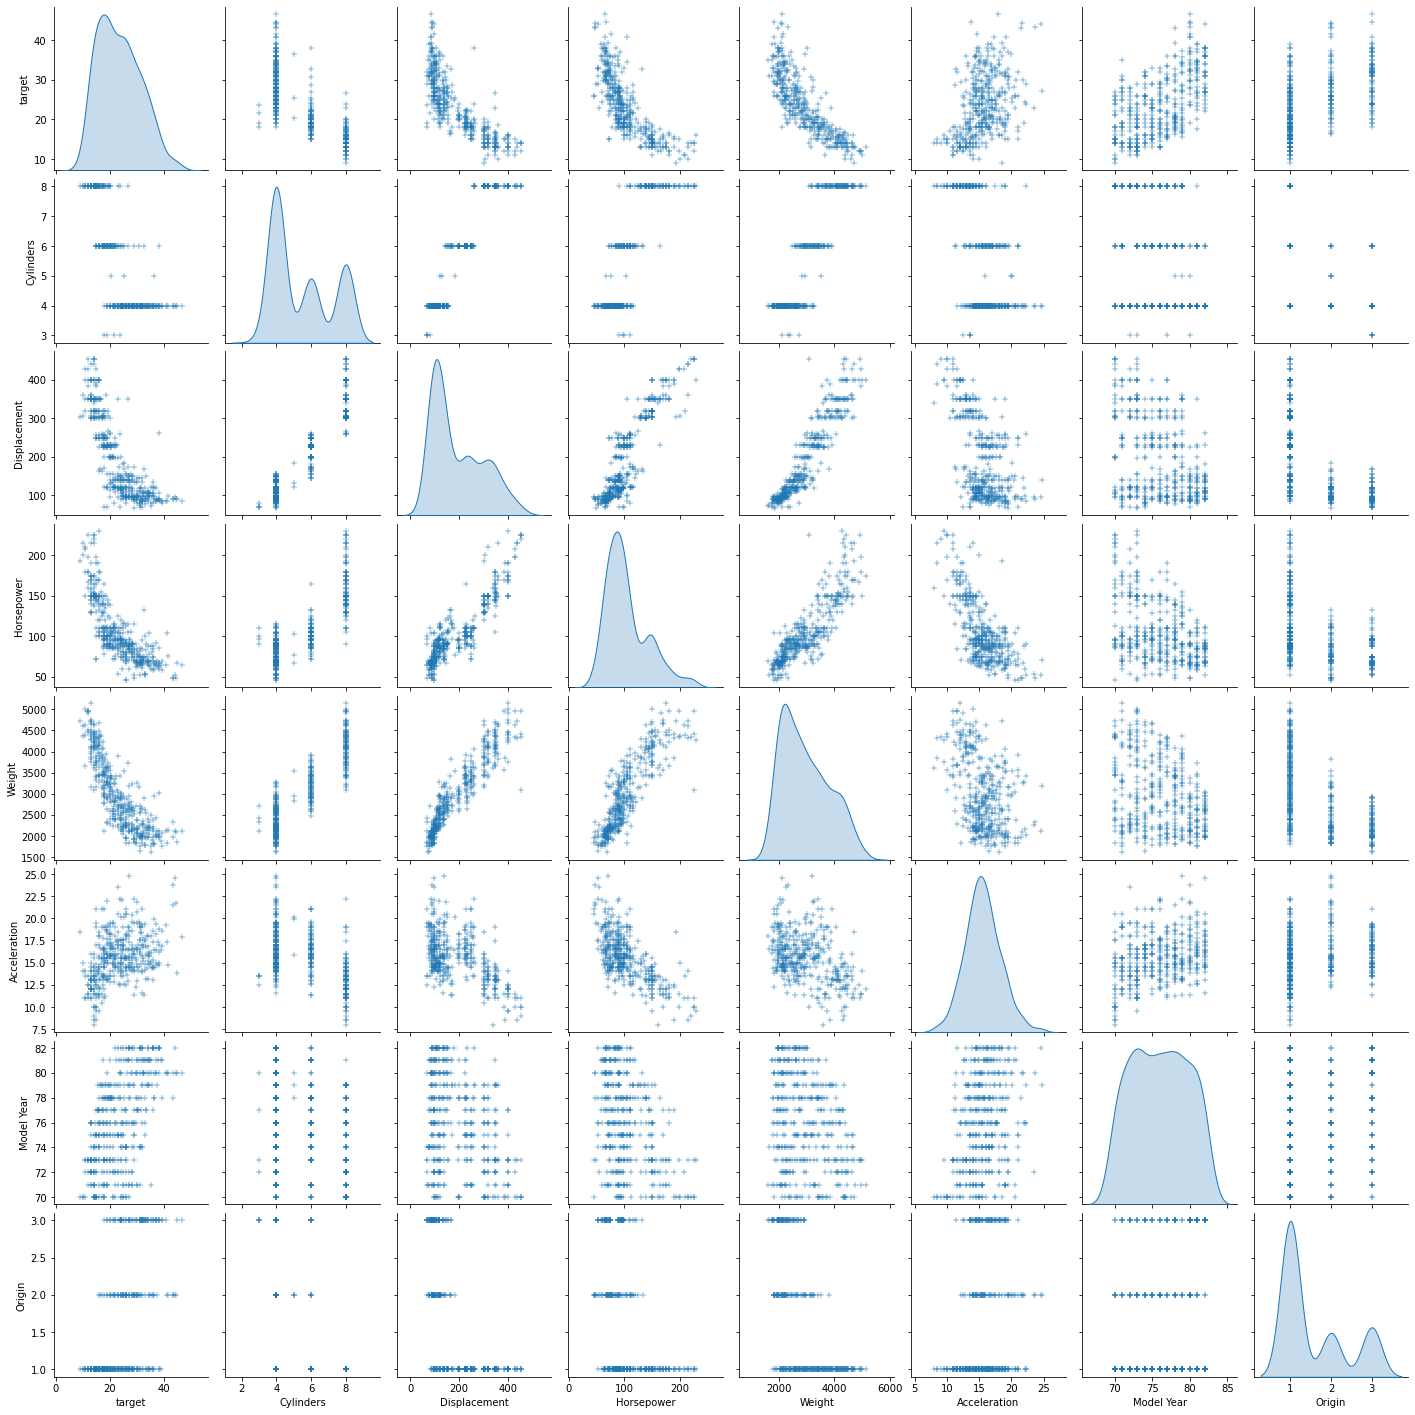

In [15]:
sns.pairplot(data, diag_kind="kde", markers = "+")
plt.show()

cylinders and origin can be categorical

4    204
8    103
6     84
3      4
5      3
Name: Cylinders, dtype: int64
1    249
3     79
2     70
Name: Origin, dtype: int64


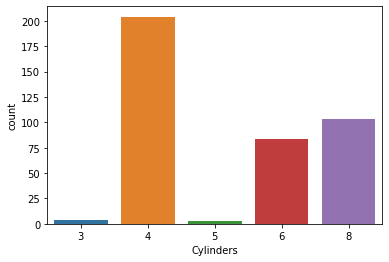

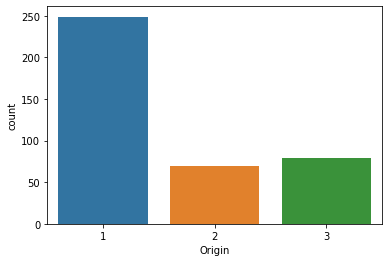

In [16]:
plt.figure()
sns.countplot(data.Cylinders)
print(data.Cylinders.value_counts())

plt.figure()
sns.countplot(data.Origin)
print(data.Origin.value_counts())

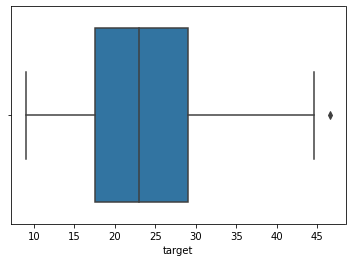

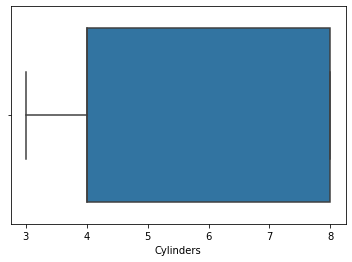

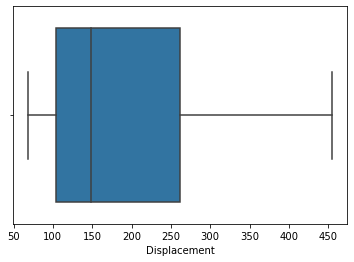

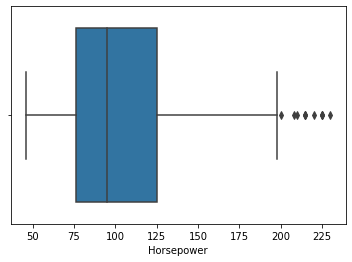

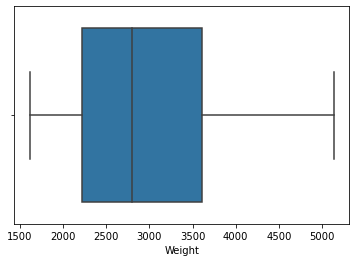

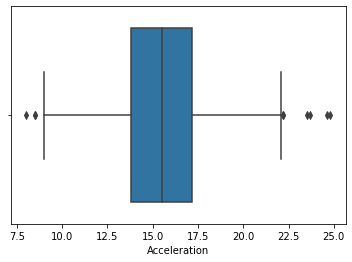

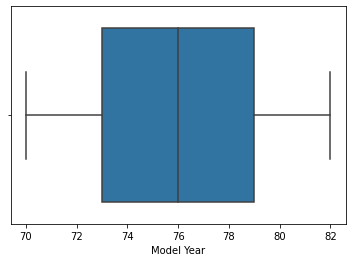

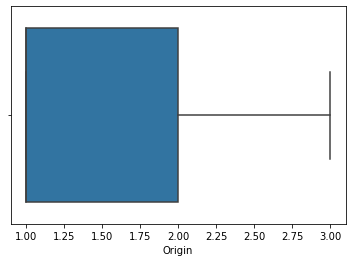

In [17]:
for c in data.columns:
    plt.figure()
    sns.boxplot(x = c, data = data, orient = "v")

outlier: horsepower and acceleration

In [18]:
thr = 2

horsepower_desc = describe["Horsepower"]
q3_hp = horsepower_desc[6]
q1_hp = horsepower_desc[4]
IQR_hp = q3_hp-q1_hp
top_limit_hp = q3_hp + thr*IQR_hp
bottom_limit_hp = q1_hp - thr*IQR_hp
filter_hp_bottom = bottom_limit_hp < data["Horsepower"]
filter_hp_top = data["Horsepower"] < top_limit_hp
filter_hp = filter_hp_bottom & filter_hp_top

data = data[filter_hp]

In [19]:
acceleration_desc = describe["Acceleration"]
q3_acc = acceleration_desc[6]
q1_acc = acceleration_desc[4]
IQR_acc = q3_acc-q1_acc
top_limit_acc = q3_acc + thr*IQR_acc
bottom_limit_acc = q1_acc - thr*IQR_acc
filter_acc_bottom = bottom_limit_acc < data["Acceleration"]
filter_acc_top = data["Acceleration"] < top_limit_acc
filter_acc = filter_acc_bottom & filter_acc_top

data = data[filter_acc]

<AxesSubplot:xlabel='target', ylabel='Density'>

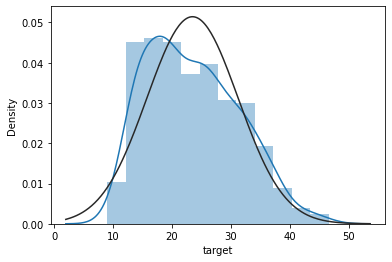

In [20]:
sns.distplot(data.target, fit = norm)

In [21]:
(mu, sigma) = norm.fit(data.target)
print("mu: {}, sigma = {}".format(mu, sigma))

mu: 23.472405063291134, sigma = 7.756119546409932


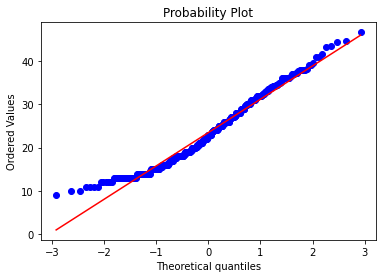

In [22]:
plt.figure()
stats.probplot(data.target, plot = plt)
plt.show()

<AxesSubplot:xlabel='target', ylabel='Density'>

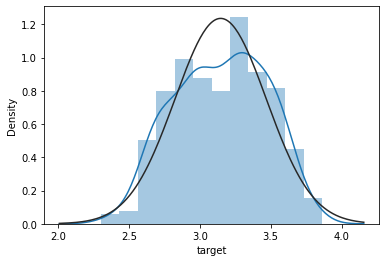

In [23]:
data.target = np.log1p(data.target)
plt.figure()
sns.distplot(data.target, fit = norm)

In [24]:
(mu, sigma) = norm.fit(data.target)
print("mu: {}, sigma = {}".format(mu, sigma))

mu: 3.146474056830183, sigma = 0.3227569103044823


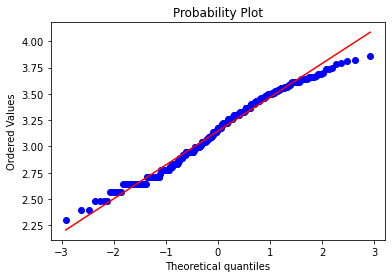

In [25]:
plt.figure()
stats.probplot(data.target, plot = plt)
plt.show()

In [26]:
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewned"])

In [27]:
skewness

,skewned
Horsepower,1.067743
Origin,0.923381
Displacement,0.714682
Weight,0.533226
Cylinders,0.523374
Acceleration,0.168986
Model Year,0.013098
target,-0.117687


In [28]:
data.Cylinders = data.Cylinders.astype(str)
data.Origin = data.Origin.astype(str)
data = pd.get_dummies(data)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 0 to 397
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        395 non-null    float64
 1   Displacement  395 non-null    float64
 2   Horsepower    395 non-null    float64
 3   Weight        395 non-null    float64
 4   Acceleration  395 non-null    float64
 5   Model Year    395 non-null    int64  
 6   Cylinders_3   395 non-null    uint8  
 7   Cylinders_4   395 non-null    uint8  
 8   Cylinders_5   395 non-null    uint8  
 9   Cylinders_6   395 non-null    uint8  
 10  Cylinders_8   395 non-null    uint8  
 11  Origin_1      395 non-null    uint8  
 12  Origin_2      395 non-null    uint8  
 13  Origin_3      395 non-null    uint8  
dtypes: float64(5), int64(1), uint8(8)
memory usage: 24.7 KB


In [30]:
x = data.drop(["target"], axis = 1)
y = data.target

test_size = 0.9
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state=42)

In [31]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [32]:
lr = LinearRegression()
lr.fit(x_train, y_train)
print("LR Coef:\n", lr.coef_)
y_predicted_dummy = lr.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("Linear Regression MSE: ", mse)

LR Coef:
 [-9.92705759e-02 -1.05006197e-01 -2.28689229e-02 -4.99057559e-02
  4.34952012e-02 -5.72828846e-02  4.72375426e-02 -5.55111512e-17
 -1.40612813e-02 -2.28840651e-02 -7.11143569e-03 -2.73464310e-02
  3.45783731e-02]
Linear Regression MSE:  0.02063220478013308


In [33]:
ridge = Ridge(random_state=42, max_iter=10000)

alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [{"alpha": alphas}]
n_folds = 5

clf = GridSearchCV(ridge, tuned_parameters, cv = n_folds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(x_train, y_train)
scores  = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Ridge Coef:\n", clf.best_estimator_.coef_)

ridge = clf.best_estimator_

print("Ridge Best Estimator:\n", ridge)

y_predicted_dummy = clf.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("Ridge MSE: ", mse)

Ridge Coef:
 [-0.07849695 -0.09734007 -0.03799319 -0.04613241  0.04520109 -0.0535352
  0.05108925  0.         -0.01455674 -0.02919833 -0.00857541 -0.02556196
  0.03459116]
Ridge Best Estimator:
 Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Ridge MSE:  0.019725338010801185


Text(0.5, 1.0, 'Ridge')

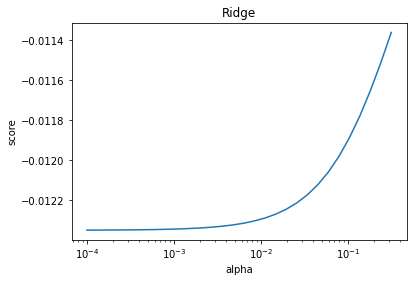

In [34]:
plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")

In [35]:
lasso = Lasso(random_state=42, max_iter=10000)

alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [{"alpha": alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv = n_folds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(x_train, y_train)
scores  = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Lasso Coef:\n", clf.best_estimator_.coef_)

lasso = clf.best_estimator_

print("Lasso Best Estimator:\n", ridge)

y_predicted_dummy = clf.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("Lasso MSE: ", mse)

Lasso Coef:
 [-0.03758778 -0.08757891 -0.0646061  -0.02803523  0.0491826  -0.03359315
  0.071679    0.          0.         -0.01794883 -0.         -0.00408397
  0.04250482]
Lasso Best Estimator:
 Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Lasso MSE:  0.01752159477082249


Text(0.5, 1.0, 'Lasso')

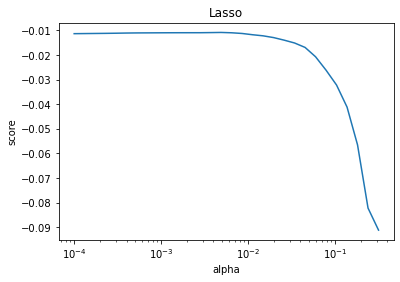

In [36]:
plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")

In [37]:
enet = ElasticNet(random_state=42, max_iter=10000)

parameterGrid = {"alpha" : alphas,
                "l1_ratio": np.arange(0.0, 1.0, 0.05)}

clf = GridSearchCV(enet, parameterGrid, cv = n_folds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(x_train, y_train)

print("Enet Coef:\n", clf.best_estimator_.coef_)
print("Enet Best Estimator:\n", clf.best_estimator_)

y_predicted_dummy = clf.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("Enet MSE: ", mse)

Enet Coef:
 [-0.04521908 -0.07808085 -0.06742275 -0.024673    0.04776549 -0.03439345
  0.06689553  0.         -0.         -0.01879676 -0.         -0.00575413
  0.03999268]
Enet Best Estimator:
 ElasticNet(alpha=0.04520353656360245, l1_ratio=0.1, max_iter=10000,
           random_state=42)
Enet MSE:  0.017496092493172515


Text(0.5, 1.0, 'Enet')

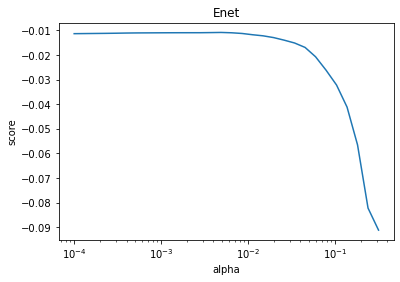

In [38]:
plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Enet")

## XGBoost

In [59]:
parameterGrid = {"nthread":[4],
                  "objective":["reg:linear"],
                  "learning_rate":[.03, .05, .07],
                  "max_depth":[5, 6, 7],
                  "min_child_weight":[4],
                  "silent":[1],
                  "subsample":[0.7],
                  "colsample_bytree":[0.7],
                  "n_estimators":[500,1000]}

In [60]:
model_xgb = xgb.XGBRegressor()
clf = GridSearchCV(model_xgb, parameterGrid, cv = n_folds, scoring = "neg_mean_squared_error", refit = True, n_jobs = 5)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [61]:
clf.fit(x_train, y_train)

[14:57:08] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:08] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=5,
        

In [62]:
model_xgb = clf.best_estimator_
y_predicted_dummy = clf.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("XGBRegressor MSE:", mse)

XGBRegressor MSE: 0.01732574388747416


## Averaging Models

In [57]:
class AveragingModels():
    def __init__(self, models):
        self.models = models
    # define clones of the original models    
    def fit(self, x, y):
        self.models_ = [clone(x) for x in self.models]
        #train
        for model in self.models_:
            model.fit(x, y)
            
        return self
    #predictions for cloned models and average them
    def predict(self, x):
        predictions = np.column_stack([model.predict(x) for model in self.models_])
        return np.mean(predictions, axis = 1)

In [64]:
averaged_models = AveragingModels(models = (model_xgb, lasso))
averaged_models.fit(x_train, y_train)

[14:57:54] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:54] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [65]:
y_predicted_dummy = averaged_models.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("Average Models MSE:", mse)

Average Models MSE: 0.016235096717582283
